In [2]:
import QNN as qnn
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

In [ ]:
def f1(x, eps=0.0):
    """The function f(x)= |x| + noise"""
    return np.abs(x) + eps * np.random.normal(size=x.shape)


def f2(x, eps=0.0):
    """The function f(x)=sin(x) + noise"""
    return np.sin(x) + eps * np.random.normal(size=x.shape)


def f3(x, eps=0.0):
    """The function f(x)=exp(x)+noise"""
    return np.exp(x) + eps * np.random.normal(size=x.shape)


def f4(x, eps=0.0):
    """The function f(x)=log(x+2*pi)+noise"""
    return np.log(x+2*np.pi) + eps * np.random.normal(size=x.shape)


def f5(x, eps=0.0):
    """The function f(x)=x^3+noise"""
    return x**3 + eps * np.random.normal(size=x.shape)

In [ ]:
# Prepare your dataset
x = np.linspace(-np.pi, np.pi, 300).reshape(-1, 1)
F = [f1, f2, f3, f4, f5]
Y = np.array([f(x, eps=0.1) for f in F])

def min_max_normalize(data):
    min_val = data.min(axis=1, keepdims=True)
    max_val = data.max(axis=1, keepdims=True)
    return (data - min_val) / (max_val - min_val)

# Normalize each result individually
Y = min_max_normalize(Y)

In [ ]:
abs_lr = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=0.01,
    decay_steps=1000,
    end_learning_rate=0.001,
    power=2.0
)

trig_lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,  
    decay_steps=1000,              
    decay_rate=1                
)
    
exp_lr = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=0.01,
    decay_steps=1000,
    end_learning_rate=0.0001,
    power=3.0
)

log_lr = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01,
    decay_steps=1000,
    decay_rate=0.95,
)

cube_lr = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,  
    decay_steps=1000,              
    decay_rate=0.9                
)
    
rates = [abs_lr, trig_lr, exp_lr, log_lr, cube_lr]

In [5]:
# Train the model
results = []
layers = [2,3,2,2,2]
for i in range(5):
    results.append(qnn.train_model(x, Y[i], i+1, learning_rate=rates[i], num_layers=layers[i], cutoff_dim=30, epochs=200))
H, M = zip(*results)

In [ ]:
# Train the model
classical_results = []
layers = [2,3,2,2,2]
for i in range(5):
    results.append(qnn.train_classical_model(x, Y[i], i+1, learning_rate=rates[i], num_layers=layers[i], epochs=200))
H, M = zip(*classical_results)

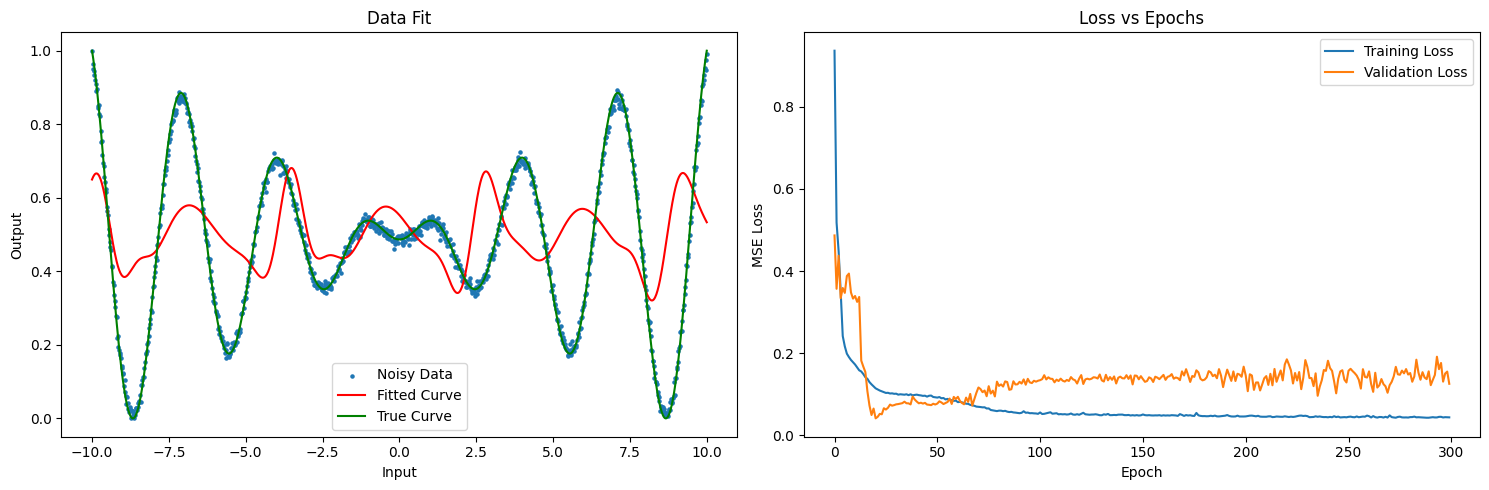

In [10]:
fit = plt.figure(figsize=(14, 10))
gs = plt.GridSpec(2, 12)

Y_preds = [model.predict(x, verbose = 0) for model in M]
y_labels = [
    r'$f(x) = |x| + \text{noise}$',
    r'$f(x) = \frac{\sin(\pi x)}{\pi x} + \text{noise}$',
    r'$f(x) = \exp(x) + \text{noise}$',
    r'$f(x) = \log(x+2\pi) + \text{noise}$',
    r'$f(x) = x^3 + \text{noise}$'
]

for i in range(5):
    if i < 3:
        ax = plt.subplot(gs[0, 4 * i:4 * i + 4])
    else:
        # Center the bottom plots by shifting them to the right
        ax = plt.subplot(gs[1, 4 * (i - 3) + 2:4 * (i - 3) + 6])
    
    y = Y[i]
    y_pred = Y_preds[i]
    ax.scatter(x, y, s=5, label="Noisy Data")
    ax.scatter(x, y_pred, s=5, label='Fitted Curve', color='r')
    ax.set_title(f'Data fit {i+1}')
    ax.set_xlabel(r'$x$') 
    ax.set_ylabel(y_labels[i])
    ax.set_box_aspect(1)

plt.tight_layout()
fit.savefig('fits.png')
plt.show()

In [ ]:
cost = plt.figure(figsize=(14, 10))
gs = plt.GridSpec(2, 12)

for i in range(5):
    if i < 3:
        ax = plt.subplot(gs[0, 4 * i:4 * i + 4])
    else:
        # Center the bottom plots by shifting them to the right
        ax = plt.subplot(gs[1, 4 * (i - 3) + 2:4 * (i - 3) + 6])
    
    ax.plot(H[i].history['loss'], label='Training Loss')
    ax.plot(H[i].history['val_loss'], label='Validation Loss')
    ax.set_title("Losses for: " + y_labels[i])
    ax.set_xlabel('Epochs') 
    ax.set_ylabel('Loss')
    ax.set_box_aspect(1)

plt.tight_layout()
cost.savefig('mse_with_val.png')
plt.show()

In [ ]:
r2 = plt.figure(figsize=(14, 10))
gs = plt.GridSpec(2, 12)

for i in range(5):
    if i < 3:
        ax = plt.subplot(gs[0, 4 * i:4 * i + 4])
    else:
        # Center the bottom plots by shifting them to the right
        ax = plt.subplot(gs[1, 4 * (i - 3) + 2:4 * (i - 3) + 6])
    
    ax.plot(H[i].history['r2_score'], label='Training R2 Score')
    ax.plot(H[i].history['val_r2_score'], label='R2 Score')
    ax.set_title("R2 Scores for: " + y_labels[i])
    ax.set_xlabel('Epochs') 
    ax.set_ylabel('R2 Score')
    ax.set_ybound(-3,1.2)
    ax.set_box_aspect(1)

plt.tight_layout()
r2.savefig('r2_with_val.png')
plt.show()